In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from PIL import Image
import cv2
import os
from sklearn.model_selection import train_test_split 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
import matplotlib.pyplot as plt
#import plotly.express as px
import random
from keras.losses import SparseCategoricalCrossentropy
from collections import Counter

2024-12-11 15:28:59.870040: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-11 15:28:59.882678: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-11 15:28:59.886354: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-11 15:28:59.895277: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import tensorflow as tf

# List available physical devices
gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs:", gpus)


Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1733927343.131382    4228 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733927343.178782    4228 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1733927343.178863    4228 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [3]:
# Function to detect blurry images using Laplacian variance
def is_blurry(image, threshold=100):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    variance = cv2.Laplacian(gray_image, cv2.CV_64F).var()
    return variance < threshold

# Function to sharpen the image
def sharpen_image(image):
    kernel = np.array([
        [-1, -1, -1],
        [-1,  9, -1],
        [-1, -1, -1]
    ])
    sharpened = cv2.filter2D(image, -1, kernel)
    return sharpened

In [4]:
import cv2
import numpy as np
from PIL import ImageEnhance

def enhance_dark_image(image):
    """
    Enhance images that are too dark using adaptive histogram equalization and brightness adjustment,
    with noise reduction to avoid amplifying noise.
    """
    # Convert to grayscale to analyze brightness
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    mean_brightness = np.mean(gray)

    # If the mean brightness is below a threshold, enhance the image
    if mean_brightness < 60:  # Threshold can be adjusted based on your dataset
        # Apply slight Gaussian blur for noise reduction
        image = cv2.GaussianBlur(image, (5, 5), 0)

        # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        image_lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
        l, a, b = cv2.split(image_lab)

        # Apply CLAHE only to the L (lightness) channel
        l = clahe.apply(l)
        enhanced_image_lab = cv2.merge((l, a, b))
        image = cv2.cvtColor(enhanced_image_lab, cv2.COLOR_LAB2RGB)

        # Adjust brightness only if it's really needed
        pil_image = Image.fromarray(image)
        enhancer = ImageEnhance.Brightness(pil_image)
        brightness_factor = 1 + (60 - mean_brightness) / 100.0  # Gradual increase based on brightness level
        image = np.array(enhancer.enhance(brightness_factor))  # Apply dynamic brightness enhancement

    return image

Image 00000_00002_00000_png.rf.3f5868e97a26b188b4d3ce823c6e9c2f.jpg is blurry, sharpening...
Image 00000_00002_00001_png.rf.3cef739224527428e387081193bd420b.jpg is blurry, sharpening...
Image 00000_00002_00001_png.rf.b3a05eda45b885ae1a472c7547721760.jpg is blurry, sharpening...
Image 00000_00002_00002_png.rf.02a1b30e881b936472e3872b5e7cf3b0.jpg is blurry, sharpening...
Image 00000_00002_00002_png.rf.2df6f5515035d2e03ba24ec9e622753a.jpg is blurry, sharpening...
Image 00000_00002_00003_png.rf.98523532781dd4a1df08bbddeef993ad.jpg is blurry, sharpening...
Image 00000_00002_00003_png.rf.dbd1e2336ba48e0575fb5b91b48e6af8.jpg is blurry, sharpening...
Image 00000_00002_00004_png.rf.42fa00c6a4d5575600e9de72a47bb7a4.jpg is blurry, sharpening...
Image 00000_00002_00004_png.rf.a628aaae48b8d9635585e79879bd2788.jpg is blurry, sharpening...
Image 00000_00002_00005_png.rf.4a27eb57929561fce8d7295d6e5a02d4.jpg is blurry, sharpening...
Image 00000_00002_00006_png.rf.5cf10a07acd232b133e564cc9f0b058b.jpg is

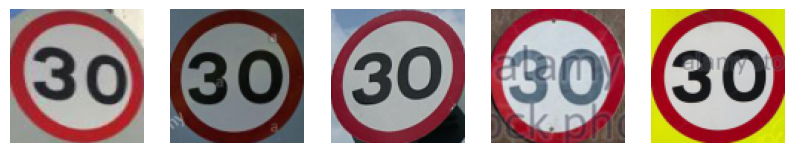

Image 00000_00002_00000_png.rf.3f5868e97a26b188b4d3ce823c6e9c2f.jpg is blurry, sharpening...
Image 00000_00002_00001_png.rf.3cef739224527428e387081193bd420b.jpg is blurry, sharpening...
Image 00000_00002_00001_png.rf.b3a05eda45b885ae1a472c7547721760.jpg is blurry, sharpening...
Image 00000_00002_00002_png.rf.02a1b30e881b936472e3872b5e7cf3b0.jpg is blurry, sharpening...
Image 00000_00002_00002_png.rf.2df6f5515035d2e03ba24ec9e622753a.jpg is blurry, sharpening...
Image 00000_00002_00003_png.rf.98523532781dd4a1df08bbddeef993ad.jpg is blurry, sharpening...
Image 00000_00002_00003_png.rf.dbd1e2336ba48e0575fb5b91b48e6af8.jpg is blurry, sharpening...
Image 00000_00002_00004_png.rf.42fa00c6a4d5575600e9de72a47bb7a4.jpg is blurry, sharpening...
Image 00000_00002_00004_png.rf.a628aaae48b8d9635585e79879bd2788.jpg is blurry, sharpening...
Image 00000_00002_00005_png.rf.4a27eb57929561fce8d7295d6e5a02d4.jpg is blurry, sharpening...
Image 00000_00002_00006_png.rf.5cf10a07acd232b133e564cc9f0b058b.jpg is

In [ ]:
def fetch_image_with_detection_and_visualization(data_folder):
    """
    Fetch images and corresponding labels, perform detection (crop based on bounding boxes),
    and resize to fit the classifier's input. Also visualizes a sample cropped image.
    """
    train_data = []
    test_data = []
    valid_data = []
    cropped_samples = []  # To store a few sample cropped images for visualization

    splits = {
        "train": os.path.join(data_folder, "train"),
        "test": os.path.join(data_folder, "test"),
        "valid": os.path.join(data_folder, "valid")
    }

    for split_name, split_path in splits.items():
        images_folder = os.path.join(split_path, "images")
        labels_folder = os.path.join(split_path, "labels")

        for image_name in os.listdir(images_folder):
            label_name = os.path.splitext(image_name)[0] + ".txt"
            label_path = os.path.join(labels_folder, label_name)
            image_path = os.path.join(images_folder, image_name)

            if not os.path.exists(label_path):
                print(f"Warning: Label file not found for {image_name}")
                continue

            # Load the image without converting to grayscale
            img = Image.open(image_path)
            image_width, image_height = img.size
            img = np.array(img)
            
            # Enhance dark images
            img = enhance_dark_image(img)

            # Detect and sharpen blurry images
            if is_blurry(img):
                print(f"Image {image_name} is blurry, sharpening...")
                img = sharpen_image(img)

            # Parse the label file for bounding boxes
            with open(label_path, "r") as label_file:
                lines = label_file.readlines()
                for line in lines:
                    parts = line.strip().split()
                    class_id = int(parts[0])  # First value is the class ID

                    # Parse normalized bounding box values
                    x_center, y_center, width, height = map(float, parts[1:])

                    # Convert to pixel coordinates
                    x_min = int((x_center - width / 2) * image_width)
                    y_min = int((y_center - height / 2) * image_height)
                    x_max = int((x_center + width / 2) * image_width)
                    y_max = int((y_center + height / 2) * image_height)

                    # Crop the detected region
                    cropped_img = img[y_min:y_max, x_min:x_max]

                    # Resize to match classifier input
                    resized_img = cv2.resize(cropped_img, (90, 90), interpolation=cv2.INTER_AREA)

                    # Normalize the image
                    resized_img = resized_img / 255.0

                    # Store a sample cropped image for visualization (only store the first few samples)
                    if len(cropped_samples) < 5:  # Limit to 5 samples
                        cropped_samples.append(resized_img)

                    # Assign the cropped image and its label to the appropriate split
                    if split_name == "train":
                        train_data.append((resized_img, class_id))
                    elif split_name == "test":
                        test_data.append((resized_img, class_id))
                    elif split_name == "valid":
                        valid_data.append((resized_img, class_id))

    # Visualize a few cropped images
    if cropped_samples:
        plt.figure(figsize=(10, 10))
        for i, cropped_img in enumerate(cropped_samples):
            plt.subplot(1, len(cropped_samples), i+1)
            plt.imshow(cropped_img)
            plt.axis('off')
        plt.show()

    return train_data, test_data, valid_data
# Fetch and visualize the cropped images
data_folder = "./DataSet"
train_data, test_data, valid_data = fetch_image_with_detection_and_visualization(data_folder)
# Fetch and visualize the cropped images
data_folder = "./DataSet"
train_data, test_data, valid_data = fetch_image_with_detection_and_visualization(data_folder)

In [ ]:
# Count the number of samples per class in each dataset
train_class_counts = Counter(class_id for _, class_id in train_data)
valid_class_counts = Counter(class_id for _, class_id in valid_data)
test_class_counts = Counter(class_id for _, class_id in test_data)

# Sort the counts for consistent visualization
train_classes, train_num_of_samples = zip(*sorted(train_class_counts.items()))
valid_classes, valid_num_of_samples = zip(*sorted(valid_class_counts.items()))
test_classes, test_num_of_samples = zip(*sorted(test_class_counts.items()))

# Plot the distributions for all splits
plt.figure(figsize=(16, 8))

# Training Dataset
plt.subplot(3, 1, 1)
plt.bar(train_classes, train_num_of_samples, color='skyblue')
plt.title("Distribution of the Training Dataset")
plt.xlabel("Class Number")
plt.ylabel("Number of Images")
plt.xticks(train_classes)

# Validation Dataset
plt.subplot(3, 1, 2)
plt.bar(valid_classes, valid_num_of_samples, color='lightgreen')
plt.title("Distribution of the Validation Dataset")
plt.xlabel("Class Number")
plt.ylabel("Number of Images")
plt.xticks(valid_classes)

# Test Dataset
plt.subplot(3, 1, 3)
plt.bar(test_classes, test_num_of_samples, color='salmon')
plt.title("Distribution of the Test Dataset")
plt.xlabel("Class Number")
plt.ylabel("Number of Images")
plt.xticks(test_classes)

# Show the combined plot
plt.tight_layout()
plt.show()

In [ ]:
# Prepare training data features and labels
training_data_features, training_data_labels = zip(*train_data)
training_data_features = np.array(training_data_features).reshape(-1, 90, 90, 3)  # Add channel dimension
training_data_labels = np.array(training_data_labels)

# Prepare validation data
validation_data_features, validation_data_labels = zip(*valid_data)
validation_data_features = np.array(validation_data_features).reshape(-1, 90, 90, 3)
validation_data_labels = np.array(validation_data_labels)

# Prepare test data
test_data_features, test_data_labels = zip(*test_data)
test_data_features = np.array(test_data_features).reshape(-1, 90, 90, 3)
test_data_labels = np.array(test_data_labels)

In [ ]:
# Check the shape of features and labels
print(f"Training data features shape: {np.array(training_data_features).shape}")
print(f"Training data labels shape: {np.array(training_data_labels).shape}")

In [ ]:
unique_labels, label_counts = np.unique(training_data_labels, return_counts=True)
for label, count in zip(unique_labels, label_counts):
    print(f"Label {label}: {count} occurrences")

In [ ]:
from keras.src.legacy.preprocessing.image import ImageDataGenerator

# Define the data augmentation pipeline
datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.1,
    rotation_range=45, 
    horizontal_flip=False,
    vertical_flip=False
)

# Fit the generator to your training data
datagen.fit(training_data_features)

In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import TensorBoard

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Stop training if no improvement for 3 consecutive epochs
    restore_best_weights=True  # Restore the best model weights after stopping
)
# Define the ReduceLROnPlateau callback
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',  # Monitor validation loss
    factor=0.5,          # Reduce the learning rate by half
    patience=2,          # After 2 epochs of no improvement
    min_lr=1e-6          # Set a lower bound for the learning rate
)


In [ ]:
cnnModel = Sequential()

cnnModel.add(Conv2D(16, (5,5), padding="same", input_shape=(90, 90, 3), activation='relu'))
cnnModel.add(MaxPool2D((2,2), strides=None, padding="same"))

cnnModel.add(Conv2D(32, (5,5), padding="same", activation='relu'))
cnnModel.add(MaxPool2D((2,2), strides=None, padding="same"))

cnnModel.add(Conv2D(64, (3,3), padding="same", activation='relu'))
cnnModel.add(MaxPool2D((2,2), strides=None, padding="same"))

cnnModel.add(Conv2D(128, (3,3), padding="same", activation='relu'))
cnnModel.add(MaxPool2D((2,2), strides=None, padding="same"))

cnnModel.add(Flatten())
cnnModel.add(Dense(256, activation='relu'))
cnnModel.add(Dense(128, activation='relu'))
cnnModel.add(Dense(15, activation='softmax'))

In [ ]:
cnnModel.summary()

In [ ]:
cnnModel.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [ ]:
SignTraffic = cnnModel.fit(
    datagen.flow(training_data_features, training_data_labels, batch_size=32),
    validation_data=(validation_data_features, validation_data_labels),
    epochs=40,
)

In [ ]:
import seaborn as sns
sns.lineplot(SignTraffic.history['accuracy'])

In [ ]:
import matplotlib.pyplot as plt
# Assuming history is the result of the model's fit() method
plt.plot(SignTraffic.history['accuracy'], label='Training Accuracy')
plt.plot(SignTraffic.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(SignTraffic.history['loss'], label='Training Loss')
plt.plot(SignTraffic.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


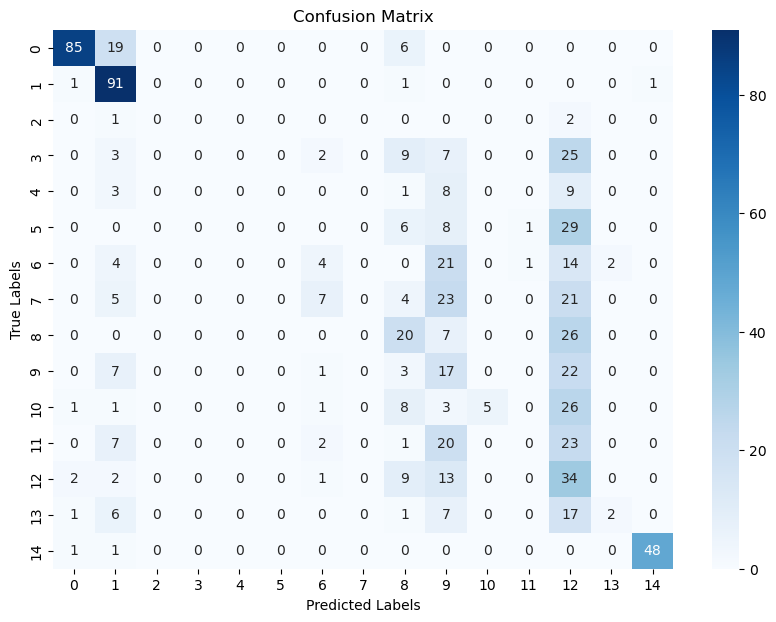

In [48]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predict the labels on the test data
test_predictions = cnnModel.predict(test_data_features)
# Convert predictions from probabilities to class labels (use argmax to get the index of the highest probability)
test_predictions = np.argmax(test_predictions, axis=1)

# Generate confusion matrix
cm = confusion_matrix(test_data_labels, test_predictions)

# Plot the confusion matrix using seaborn for better visualization
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(test_data_labels), yticklabels=np.unique(test_data_labels))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [49]:
from sklearn.metrics import classification_report
print(classification_report(test_data_labels, test_predictions))

              precision    recall  f1-score   support

           0       0.93      0.77      0.85       110
           1       0.61      0.97      0.75        94
           2       0.00      0.00      0.00         3
           3       0.00      0.00      0.00        46
           4       0.00      0.00      0.00        21
           5       0.00      0.00      0.00        44
           6       0.22      0.09      0.12        46
           7       0.00      0.00      0.00        60
           8       0.29      0.38      0.33        53
           9       0.13      0.34      0.18        50
          10       1.00      0.11      0.20        45
          11       0.00      0.00      0.00        53
          12       0.14      0.56      0.22        61
          13       0.50      0.06      0.11        34
          14       0.98      0.96      0.97        50

    accuracy                           0.40       770
   macro avg       0.32      0.28      0.25       770
weighted avg       0.40   

/home/user/miniconda3/envs/tf2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/user/miniconda3/envs/tf2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/user/miniconda3/envs/tf2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

In [30]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Calculate metrics for each class
for i in range(cm.shape[0]):
    tp = cm[i, i]
    fp = cm[:, i].sum() - tp  # sum of the column - TP
    fn = cm[i, :].sum() - tp  # sum of the row - TP
    tn = cm.sum() - (tp + fp + fn)
    
    # Calculate Precision, Recall, F1-Score, and Accuracy
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    print(f"Class {i}:")
    print(f"True Positive (TP): {tp}")
    print(f"False Positive (FP): {fp}")
    print(f"False Negative (FN): {fn}")
    print(f"True Negative (TN): {tn}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print()


Class 0:
True Positive (TP): 101
False Positive (FP): 1
False Negative (FN): 9
True Negative (TN): 659
Precision: 0.9902
Recall: 0.9182
F1-Score: 0.9528
Accuracy: 0.9870

Class 1:
True Positive (TP): 89
False Positive (FP): 10
False Negative (FN): 5
True Negative (TN): 666
Precision: 0.8990
Recall: 0.9468
F1-Score: 0.9223
Accuracy: 0.9805

Class 2:
True Positive (TP): 3
False Positive (FP): 1
False Negative (FN): 0
True Negative (TN): 766
Precision: 0.7500
Recall: 1.0000
F1-Score: 0.8571
Accuracy: 0.9987

Class 3:
True Positive (TP): 44
False Positive (FP): 5
False Negative (FN): 2
True Negative (TN): 719
Precision: 0.8980
Recall: 0.9565
F1-Score: 0.9263
Accuracy: 0.9909

Class 4:
True Positive (TP): 17
False Positive (FP): 1
False Negative (FN): 4
True Negative (TN): 748
Precision: 0.9444
Recall: 0.8095
F1-Score: 0.8718
Accuracy: 0.9935

Class 5:
True Positive (TP): 42
False Positive (FP): 1
False Negative (FN): 2
True Negative (TN): 725
Precision: 0.9767
Recall: 0.9545
F1-Score: 0.96

In [31]:
cnnModel.save("models/model.keras")

In [32]:
from PIL import Image
import numpy as np

def preprocess_image(image_path):
    img = Image.open(image_path)
    print(f"Original Image Size: {img.size}")
    img = img.resize((90, 90))
    img_array = np.array(img)
    # If the image is grayscale (2D array), convert it to 3 channels (RGB)
    if len(img_array.shape) == 2:  # Grayscale image (2D array)
        img_array = np.stack([img_array] * 3, axis=-1)
    
    img_array = img_array / 255.0
    img_array = img_array.reshape(-1, 90, 90, 3)
    print(f"Image Resize: {img_array.shape}")
    return img_array

In [33]:
def predict_image(image_path, model):
    img_array = preprocess_image(image_path)   
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis=1)[0]
    predicted_probability = np.max(predictions, axis=1)[0]
    return predicted_class, predicted_probability

Original Image Size: (400, 267)
Image Resize: (1, 90, 90, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step
Predicted Class: 1
Prediction Probability: 1.0000


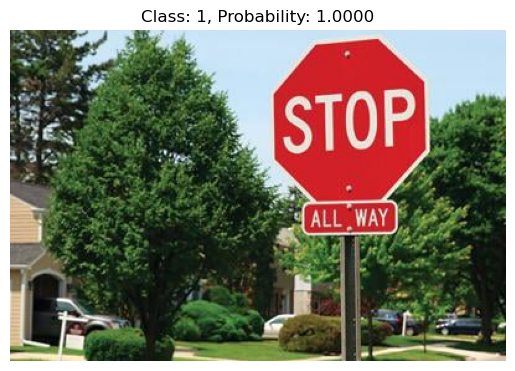

In [34]:
# Example usage
test_path = r"images/777673ad-9767-47e6-8dbc-6a1a5479636c.jpeg" 
expected_size=(90, 90)
predicted_class, predicted_probability = predict_image(test_path, cnnModel)
print(f"Predicted Class: {predicted_class}")
print(f"Prediction Probability: {predicted_probability:.4f}")
# Display the image
img = Image.open(test_path)
plt.imshow(img)
plt.axis('off')  # Hide the axes
plt.title(f"Class: {predicted_class}, Probability: {predicted_probability:.4f}")
plt.show()